&nbsp;

# 18 -  Classic Machine Learning

--- 

&nbsp;

## 1. Introduction

> #### Pourquoi faire du Machine Learning Classique ?
Le but du machine learning classique ici est de vérifier si l'utilisation du SciML dans notre projet présente un interêt ou bien si on peut se contenter d'un modèle plus simple.

&nbsp;

On commence par charger notre état réduit prétraité puis on vérifie ensuite que nos données sont cohérentes pour s'assurer de la précision de nos modélisations.

In [1]:
import numpy as np 

data = np.load("../../data/processed/sstReducedStateCOPERNICUS20102019Prepared.npz")
# data contient le résultat final du prétraitement

PCsTrain = data["PCsTrain"] # Coefficients temporels des modes EOF
PCsVal = data["PCsVal"] # PCsTrain sur période future
tTrain = data["tTrain"] # Vecteur temps de PCsTrain
tVal = data["tVal"] # Vecteur temps de PCsVal
std = data["std"] # Ecart-type de chaque mode PCA

# Vérifications (à supprimer) ############

print(PCsTrain.shape, PCsVal.shape)
print(tTrain.shape, tVal.shape)


(2922, 150) (730, 150)
(2922,) (730,)


> #### A quoi sert exactement ce code ?
Notre code nous permet de connaître :
- l'état du système à un instant donné avec un mode spatial grâce à PCsTrain, il s'agit de notre état réduit $u(t)$
- l'état du système sur une période temporelle future PCsVal, il ne sera jamais vue par nos modèles pendant l'apprentissage 
- le vecteur temporel tTrain afin de vérifier la cohérence temporelle afin de garantir un split temporel strict
- le vecteur temporel tVal pour délimiter correctement le passé et le futur
- l'écart-type de chaque mode PCA std qui permet de connaître l'ordre de grandeur physique de chaque mode et interpréter les erreurs.

&nbsp;

---

&nbsp;

## 2. *One-step forecast*

> #### Pourquoi fait-on un *one-step forecast* ?
On veut créer un modèle qui puisse apprendre la dynamique de notre système plutôt que de simplement réaliser une prédiction. Pour ce faire on demande au modèle à partir d'un état $u(t)$ de trouver le prochain état $u(t+1)$ d'où la nécessité de faire un décalage dans notre entrée et notre sortie pour avoir des couples entrée-sortie cohérents.
De plus une fois que notre modèle sera capable de faire : $u(t) → u(t+1)$ on pourra l'adapter pour par exemple :
- prendre $u(t_{0})$
- le passer dans le modèle $u(t_{1})$
- réinjecter $u(t_{1}) → u(t_{2})$

Donc on pourra propager le système dans le temps et étudier la stabilité et la cohérence dans le temps.


In [2]:
# one-step forecast :

# suppression de la dernière ligne pour l'entrée
X_train_state = PCsTrain[:-1, :]

# suppression de la première ligne de la cible
y_train = PCsTrain[1:, :]

# ajout du temps comme feature
t_train_used = tTrain[:-1]
t_train_used = t_train_used.reshape(-1, 1)

# assemblage de l'état avec le temps
X_train = np.concatenate([X_train_state, t_train_used], axis=1)

# même opérations sur le bloc validation
X_val_state = PCsVal[:-1, :]
t_val_used  = tVal[:-1].reshape(-1, 1)     
y_val = PCsVal[1:, :]                      

X_val = np.hstack([X_val_state, t_val_used])  

# Vérifications (à supprimer) ##############

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)


X_train: (2921, 151) y_train: (2921, 150)
X_val  : (729, 151) y_val  : (729, 150)


> #### Qu'est-ce qu'on obtient avec ce code ?
On obtient ainsi un état réduit avec une date puisque la dynamique n'est pas forcément stationnaire : le réchauffement est global avec des tendances lentes et des changement de régimes. Ainsi avec l'ajout du temps le modèle pourra comparer la dynamique entre années sans pour autant casser notre structure $u(t) → u(t+1)$.

&nbsp;

> #### Pourquoi ce format est utile pour comparer les modèles ?
Cette construction permet d'avoir l'évolution locale de notre état réduit qui pourra ensuite être utilisé pour comparer différentes familles de modèles (linéaires, non linéaires ...).

## Ridge
### Pourquoi utilisons-nous le modèle de régression linéaire régularisée ?
Dans notre situation on sait que notre cas n'est pas linéaire du type : 

$y = ax + b$ 
Ainsi si on utilisait un modèle de régression linéaire "pure" qui est très sensible au bruit on se retrouverait avec des énormes erreurs au pas suivant et on obtiendrait une divergence.

Ridge est une régression linéaire avec pénalisation L2 de formule :
$min||y- X\beta||^{2} + \alpha||\beta||^2$
Ce qui nous permet d'empêcher les coefficients de devenir trop grands et de stabiliser le problème.

Enfin Ridge est particulièrement adapté aux EOF / PCA puisque les EOF sont orthogonaux dans l'espace original mais leurs coefficients temporels sont corrélés et Ridge est spécialement conçu pour gérer la multicolinéarité et les fortes dimensions.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Modèle de base
ridge_base = MultiOutputRegressor(Ridge())

# Pipeline de prétraitement et de modèle
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", ridge_base)
])

# Hyperparamètres
param_grid_ridge = {
    "ridge__estimator__alpha": [0.01, 0.1, 1, 10, 100]
}

# Apprentissage passé puis on valide sur le futur
tscv = TimeSeriesSplit(n_splits=5)

grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid_ridge,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

ridge_best = grid_ridge.best_estimator_

print("Meilleurs hyperparamètres Ridge :", grid_ridge.best_params_)
print("MSE CV Ridge :", -grid_ridge.best_score_)


Meilleurs hyperparamètres Ridge : {'ridge__estimator__alpha': 100}
MSE CV Ridge : 0.718700647354126


## Kernel Ridge


In [4]:
# définition de notre modèle
kerridgeBase = KernelRidge()

# Création de notre pipeline
pipelineKerridgeBase = Pipeline([("scaler", 
    StandardScaler()),("krr", kerridgeBase)])

# Choix de nos hyperparamètres
paramGridKerridge = {
    "krr__alpha": [1e-3,1e-2,1e-1,1,10], # Force de régularisation
    "krr__kernel": ["rbf", "poly"],
    "krr__gamma": [1e-3,1e-2,1e-1], # Portée de l'influence
    "krr__degree": [2,3] # Ordre des interactions non linéaires
}

# Validation croisée temporelle
validationCroiseeTemp = TimeSeriesSplit(n_splits=5)

# GridSearch
gridKerridge = GridSearchCV(
    pipelineKerridgeBase,
    paramGridKerridge,
    cv = validationCroiseeTemp,
    scoring="neg_mean_squared_error",
    n_jobs=1
)

# Entraînement du modèle
gridKerridge.fit(X_train, y_train)

meilleurKerridge = gridKerridge.best_estimator_
# Prédiction et erreurs
yPredictKerridge = meilleurKerridge.predict(X_val)
rmseKerridge = np.sqrt(mean_squared_error(y_val, yPredictKerridge))

mseKrr = mean_squared_error(y_val, yPredictKerridge)
rmseKrr = np.sqrt(mseKrr)


# RMSE globale
rmsePerModeKerridge = np.sqrt(np.mean((y_val - yPredictKerridge)**2,axis=0))

print("=== Kernel Ridge ===")
print("Meilleurs hyperparamètres :", gridKerridge.best_params_)
print("Meilleur score CV (MSE)   :", -gridKerridge.best_score_)
print("RMSE KRR (global) :", rmseKrr)
print("RMSE par mode (KRR) :", rmsePerModeKerridge)


=== Kernel Ridge ===
Meilleurs hyperparamètres : {'krr__alpha': 1, 'krr__degree': 3, 'krr__gamma': 0.001, 'krr__kernel': 'poly'}
Meilleur score CV (MSE)   : 0.7044283866882324
RMSE KRR (global) : 0.9667849145014586
RMSE par mode (KRR) : [0.44418588 0.5194076  0.5430376  0.6001221  0.6725589  0.62610084
 0.67865324 0.86156124 0.7477647  0.88396853 0.78165466 0.84576625
 0.77521956 0.9054764  0.7714672  0.80815274 0.9221644  0.8192478
 0.8950506  0.8897298  0.9026989  0.914489   0.8024051  0.85922265
 0.8717252  0.81891686 0.8907126  0.8774573  0.8342427  0.9692539
 0.92845905 0.86502355 0.8547122  0.8768411  0.86996865 0.94095826
 0.92553926 0.9072852  0.8911005  0.8583266  0.9536961  0.9454959
 0.90015715 0.8349444  0.95429564 0.9005387  0.86599314 0.93180907
 1.08211    1.0823117  0.9988749  0.9734512  1.1381335  0.9371569
 0.978661   0.98548466 0.9030497  0.9233481  0.89854443 0.9477583
 1.0096066  0.95268583 0.9958382  0.9559281  0.9070803  0.8945021
 0.9626261  1.1041087  1.0516882

> #### Comment interpréter nos résultats ?
On trouve $\alpha = 100$ ce qui signifie que notre modèle a besoin d'une forte régulation sur les coefficients pour être optimal.
La valeur obtenue de la MSE par validation croisée vaut environ 0.72 montre que notre dynamique d'état réduit peut être décrite en partie par une relation linéaire régularisée. L'augmentation de l'erreur pour les modes de rang élevé suggère des composantes plus bruitées et moins prédictibles.

In [5]:
y_pred_ridge = ridge_best.predict(X_val)

mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print("RMSE Ridge (global) :", rmse_ridge)

rmse_per_mode_ridge = np.sqrt(np.mean((y_val - y_pred_ridge)**2, axis=0))
print("RMSE par mode (Ridge) :", rmse_per_mode_ridge)


RMSE Ridge (global) : 0.9627987274205094
RMSE par mode (Ridge) : [0.39625752 0.50029844 0.5174921  0.57668054 0.6495896  0.61422634
 0.6522364  0.83767    0.7285807  0.8741386  0.7727087  0.8289254
 0.76158124 0.890739   0.7651489  0.799449   0.918801   0.8040187
 0.87714183 0.8766024  0.9098694  0.90245026 0.7986073  0.8484104
 0.8690122  0.8084291  0.88514346 0.87056565 0.8253365  0.9660748
 0.9101814  0.8649687  0.8528794  0.8639875  0.860115   0.92285186
 0.92222506 0.89992183 0.8916467  0.8445249  0.95203614 0.91881645
 0.8929505  0.8362511  0.9514442  0.90347713 0.8628406  0.93183804
 1.0693872  1.0789129  0.9848905  0.9508435  1.1171497  0.9327653
 0.97638875 0.98767585 0.8973125  0.91412103 0.8988933  0.9420458
 1.0054715  0.9544596  0.9834846  0.9516665  0.91317177 0.8798058
 0.96992844 1.093074   1.0505735  1.0270013  1.0243638  0.9065121
 1.0274105  0.9401182  0.9857165  0.9874809  0.99427944 1.016098
 0.9030879  1.089341   0.9383964  0.9743601  0.8944418  1.0462297
 0.97895

> #### Comment interpréter nos résultats ?
Le modèle de régression linéaire régularisée (Ridge) obtient une RMSE globale de 0.96 sur le jeu de validation, ce qui constitue la meilleure performance parmi l’ensemble des modèles testés.

L’analyse de la RMSE par mode EOF montre une augmentation progressive de l’erreur avec le rang du mode. Les premiers modes, qui concentrent la majorité de la variance du champ de SST, sont prédits avec une erreur relativement faible, tandis que les modes de rang élevé présentent une erreur plus importante. Ce comportement est cohérent avec la décroissance de l’énergie associée aux modes EOF et avec le caractère plus bruité des composantes de haut rang.

La valeur optimale élevée du paramètre de régularisation (α = 100) indique que la stabilité du modèle repose sur une forte contrainte des coefficients, ce qui confirme que la dynamique prédictible est dominée par des structures larges et robustes, plutôt que par des interactions fines entre modes.

Ces résultats suggèrent que la dynamique de l’état réduit est majoritairement linéaire et que la régression Ridge constitue une baseline robuste et efficace pour la prédiction à court terme.


&nbsp;

---

&nbsp;

## 3. Modèle MLP (Multi-Layer Perceptron)

> #### Pourquoi choisir ce modèle ?

Après avoir établi une référence à l’aide d’un modèle linéaire régularisé (Ridge), nous introduisons un réseau de neurones de type MLP afin d’évaluer l’apport de la non-linéarité dans la modélisation de la dynamique de l’état réduit.

Le MLP permet d’approximer des relations non linéaires entre l’état réduit au temps t et l’état au temps t+Δt, sans introduire de mémoire temporelle explicite. Il constitue ainsi une extension naturelle du modèle linéaire, tout en conservant une formulation instantanée du type one-step forecast.

L’objectif de ce modèle est de déterminer si la relation d’évolution de l’état réduit présente des non-linéarités suffisamment marquées pour justifier l’utilisation d’un modèle plus expressif qu’une simple régression linéaire.


In [6]:
from sklearn.neural_network import MLPRegressor

# Validation croisée adaptée aux séries temporelles
tscv = TimeSeriesSplit(n_splits=5)

mlp_base = MLPRegressor(
    max_iter=500,
    random_state=42
)

# Pipeline
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", mlp_base)
])

param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 64)],
    "mlp__activation": ["relu"],
    "mlp__alpha": [1e-4, 1e-3],
    "mlp__learning_rate_init": [1e-3]
}

grid_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)

mlp_best = grid_mlp.best_estimator_

print("Meilleurs hyperparamètres MLP :", grid_mlp.best_params_)
print("MSE CV MLP :", -grid_mlp.best_score_)

y_pred_mlp = mlp_best.predict(X_val)

mse_mlp = mean_squared_error(y_val, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)

print("RMSE MLP (global) :", rmse_mlp)

# RMSE par mode (analyse fine comme pour Ridge)
rmse_per_mode_mlp = np.sqrt(np.mean((y_val - y_pred_mlp)**2, axis=0))
print("RMSE par mode (MLP) :", rmse_per_mode_mlp)


Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (64,), 'mlp__learning_rate_init': 0.001}
MSE CV MLP : 1.0430416345596314
RMSE MLP (global) : 1.1555462835064203
RMSE par mode (MLP) : [0.6356537  0.70324665 0.72292954 0.7647652  0.9030558  0.8601517
 0.8901438  1.0802373  0.955038   1.0804075  0.9537617  1.0445734
 0.96162486 1.1340711  0.90238893 1.035353   1.1144886  0.9989324
 1.1075387  1.0937221  1.0552409  1.2001823  0.96730167 1.1110024
 1.0848904  0.98859185 1.0632296  1.0677372  1.0299269  1.102887
 1.1733805  1.0488017  1.1188991  1.058531   1.0742584  1.1349846
 1.0860056  1.0882188  1.0416571  1.0586542  1.1216917  1.154137
 1.1152745  1.0036047  1.1648841  1.0839219  1.0800401  1.1205515
 1.3302065  1.3142676  1.2039918  1.190649   1.4034269  1.1554232
 1.1938664  1.117619   1.0942965  1.1548995  1.1112602  1.1177256
 1.2105688  1.163504   1.2321111  1.1730967  1.0670959  1.0909406
 1.1702598  1.3746955  1.2705066  

> #### Comment interpréter nos résultats ?
Le modèle MLP, configuré avec une seule couche cachée de 64 neurones et une régularisation modérée, obtient une RMSE globale de 1.16, nettement supérieure à celle du modèle Ridge.

L’analyse des erreurs par mode montre que le MLP présente une dégradation systématique des performances sur l’ensemble des modes EOF, y compris les modes dominants. L’introduction de non-linéarités ne permet donc pas d’améliorer la prédiction de l’état réduit, et conduit au contraire à une augmentation de l’erreur globale.

Ce résultat suggère que les relations non linéaires instantanées entre l’état réduit au temps t et l’état au temps t+Δt sont soit faibles, soit masquées par le bruit, et que la complexité supplémentaire du MLP n’est pas justifiée dans ce cadre.

&nbsp;

---

&nbsp;

## 4. Modèle LSTM - Réseau récurrent à mémoire longue

> #### Pourquoi utiliser le modèle LSTM ?

Les modèles précédents reposent sur une hypothèse de type markovienne, dans laquelle l’évolution de l’état réduit dépend uniquement de l’état courant. Or, les systèmes océaniques sont connus pour présenter des dynamiques lentes et intégratives, impliquant une mémoire temporelle sur plusieurs pas de temps.

Le modèle LSTM est conçu pour capturer ce type de dépendances temporelles en prenant en entrée une séquence d’états passés. Il permet ainsi de tester l’hypothèse selon laquelle l’évolution de l’état réduit dépend non seulement de l’état instantané, mais également de son historique récent.

L’objectif de ce modèle est donc d’évaluer l’apport d’une mémoire temporelle explicite dans la prédiction de la dynamique réduite de la SST.


In [7]:
import numpy as np

def make_sequences(PCs, window):
    X_seq = []
    y_seq = []
    for i in range(len(PCs) - window):
        X_seq.append(PCs[i:i+window, :])      # (window, 150)
        y_seq.append(PCs[i+window, :])        # (150,)
    return np.array(X_seq), np.array(y_seq)

window = 10  # longueur de séquence

X_seq_train, y_seq_train = make_sequences(PCsTrain, window)
X_seq_val,   y_seq_val   = make_sequences(PCsVal, window)

print("X_seq_train:", X_seq_train.shape)  # (n_samples, window, 150)
print("y_seq_train:", y_seq_train.shape)  # (n_samples, 150)


X_seq_train: (2912, 10, 150)
y_seq_train: (2912, 150)


In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor

n_timesteps = X_seq_train.shape[1]   # longueur de la fenêtre temporelle
n_features  = X_seq_train.shape[2]   # nombre de modes EOF

lstm_model = keras.Sequential([
    keras.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64),
    layers.Dense(n_features)
])

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

lstm_reg = KerasRegressor(
    model=lstm_model,
    epochs=50,
    batch_size=32,
    verbose=0
)


In [9]:
# === GridSearch très simple (mais valide) ===
param_grid_lstm = {
    "batch_size": [16, 32, 64],
    "epochs": [30, 50],
}

grid_lstm = GridSearchCV(
    lstm_reg,
    param_grid_lstm,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_lstm.fit(X_seq_train, y_seq_train)

print("Meilleurs hyperparamètres LSTM :", grid_lstm.best_params_)

lstm_best = grid_lstm.best_estimator_

y_pred_lstm = lstm_best.predict(X_seq_val)
mse_lstm = mean_squared_error(y_seq_val, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
print("RMSE LSTM (global) :", rmse_lstm)


c:\Users\gaoks\Isen\ProjetM1\m1Project_SciML\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Meilleurs hyperparamètres LSTM : {'batch_size': 64, 'epochs': 30}
RMSE LSTM (global) : 1.2044003650348


> #### Comment interpréter nos résultats ?
Le modèle LSTM, conçu pour exploiter une mémoire temporelle explicite, obtient une RMSE globale de 1.20, ce qui correspond à la performance la plus faible parmi les modèles testés.

Malgré l’introduction d’une fenêtre temporelle de longueur 10, le LSTM ne parvient pas à améliorer la prédiction de l’état réduit par rapport aux modèles non récurrents. Cela indique que l’information contenue dans les états passés supplémentaires n’apporte pas de gain significatif pour la prédiction à un pas de temps dans ce cadre.

Ce résultat suggère que la dynamique de l’état réduit est essentiellement locale dans le temps et qu’une hypothèse markovienne de premier ordre constitue une approximation suffisante.

&nbsp;

---

&nbsp;

## 5. Modèle GRU - Réseau récurrent simplifié

> #### Pourquoi utiliser le modèle GRU ?

Le modèle GRU constitue une alternative au LSTM, reposant sur une architecture plus simple et un nombre réduit de paramètres. Il est souvent utilisé lorsque les données disponibles sont limitées ou lorsque l’on souhaite réduire le risque de sur-apprentissage.

Dans ce travail, le GRU est utilisé afin de comparer deux architectures récurrentes et de déterminer si une modélisation temporelle plus légère permet de mieux capturer la dynamique de l’état réduit que le LSTM.


In [10]:
from tensorflow.keras.layers import GRU

# Dimensions des séquences
n_timesteps = X_seq_train.shape[1]  
n_features  = X_seq_train.shape[2]  

# Définition du modèle GRU (inline)
gru_model = keras.Sequential([
    keras.Input(shape=(n_timesteps, n_features)),
    GRU(64),
    layers.Dense(n_features)
])

gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

# Wrapper SciKeras pour intégration avec scikit-learn
gru_reg = KerasRegressor(
    model=gru_model,
    epochs=50,
    batch_size=32,
    verbose=0
)

param_grid_gru = {
    "model__gru__units": [32, 64],        # nombre de neurones GRU
    "optimizer__learning_rate": [1e-3, 5e-4],
    "batch_size": [32],
    "epochs": [50]
}

grid_gru = GridSearchCV(
    gru_reg,
    param_grid_gru,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_gru.fit(X_seq_train, y_seq_train)

print("Meilleurs hyperparamètres GRU :", grid_gru.best_params_)

gru_best = grid_gru.best_estimator_

# Prédiction sur la validation
y_pred_gru = gru_best.predict(X_seq_val)

# Calcul des erreurs
mse_gru = mean_squared_error(y_seq_val, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)

print("RMSE GRU (global) :", rmse_gru)



c:\Users\gaoks\Isen\ProjetM1\m1Project_SciML\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Meilleurs hyperparamètres GRU : {'batch_size': 32, 'epochs': 50, 'model__gru__units': 32, 'optimizer__learning_rate': 0.0005}
RMSE GRU (global) : 1.2018500669752714


> #### Comment interpréter nos résultats ?
Le modèle GRU obtient une RMSE globale de 1.17, légèrement inférieure à celle du LSTM mais toujours supérieure à celles des modèles non récurrents.

La meilleure performance relative du GRU par rapport au LSTM peut s’expliquer par une architecture plus simple et un nombre réduit de paramètres, mieux adaptée à la taille limitée du jeu de données. Néanmoins, l’introduction d’une mémoire temporelle explicite ne permet pas d’atteindre les performances du modèle linéaire régularisé.

Ces résultats confirment que, dans ce cas d’étude, la mémoire temporelle sur plusieurs pas n’est pas un facteur déterminant pour la prédiction à court terme de l’état réduit.

&nbsp;

---

&nbsp;

## 6. Conclusion 
L’ensemble des modèles de Machine Learning testés met en évidence une hiérarchie claire des performances. La régression linéaire régularisée (Ridge) obtient la meilleure performance globale, suivie du MLP, puis des modèles récurrents GRU et LSTM.

Le fait que le modèle linéaire régularisé surpasse des architectures plus complexes suggère que la dynamique projetée sur l’état réduit de la SST est majoritairement linéaire et faiblement dépendante de l’historique temporel à court terme. Les non-linéarités instantanées et la mémoire temporelle explicite n’apportent pas de gain significatif dans la prédiction one-step.

Dans ce contexte, le modèle Ridge apparaît comme le meilleur compromis entre performance, stabilité numérique et interprétabilité. Il constitue donc le modèle retenu pour la suite de l’étude, et sert de référence pour discuter des limites du ML classique et de l’intérêt potentiel d’approches plus structurées.


---

## 7. Approfondissement du ML classique

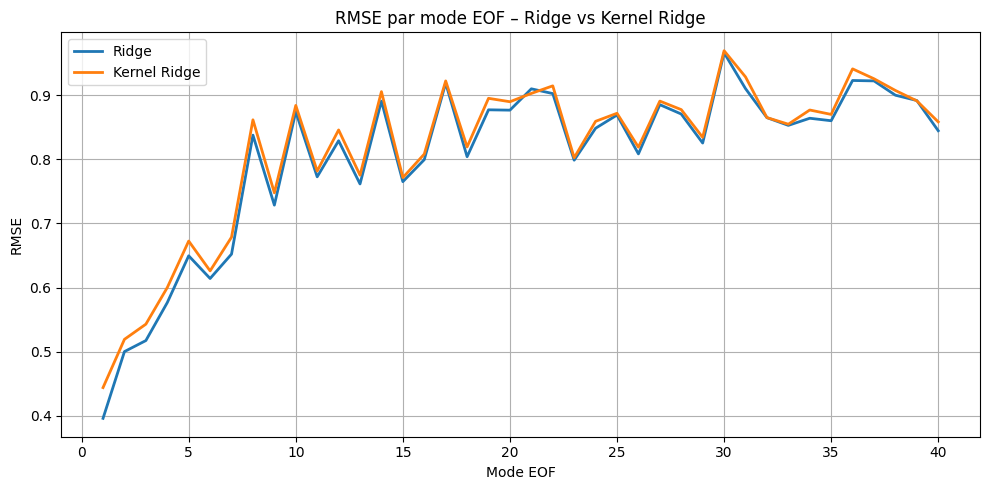

In [11]:
import matplotlib.pyplot as plt

# Nombre de modes à afficher
n_modes_plot = 40

modes = np.arange(1, n_modes_plot + 1)

plt.figure(figsize=(10, 5))

plt.plot(
    modes,
    rmse_per_mode_ridge[:n_modes_plot],
    label="Ridge",
    linewidth=2
)

plt.plot(
    modes,
    rmsePerModeKerridge[:n_modes_plot],
    label="Kernel Ridge",
    linewidth=2
)

plt.xlabel("Mode EOF")
plt.ylabel("RMSE")
plt.title("RMSE par mode EOF – Ridge vs Kernel Ridge")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Modèle Random Forest
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Grille d'hyperparamètres (raisonnable pour ne pas exploser le temps)
param_grid_rf = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

tscv = TimeSeriesSplit(n_splits=5)

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

rf_best = grid_rf.best_estimator_

print("=== Random Forest ===")
print("Meilleurs hyperparamètres :", grid_rf.best_params_)
print("MSE CV RF :", -grid_rf.best_score_)

# Prédiction
y_pred_rf = rf_best.predict(X_val)

mse_rf  = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("RMSE RF (global) :", rmse_rf)

rmse_per_mode_rf = np.sqrt(np.mean((y_val - y_pred_rf)**2, axis=0))
print("RMSE par mode (RF) :", rmse_per_mode_rf)


c:\Users\gaoks\Isen\ProjetM1\m1Project_SciML\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Modèle de base
gbr_base = GradientBoostingRegressor(
    random_state=42
)

# Wrapper multi-output
gbr = MultiOutputRegressor(gbr_base)

# Grille d'hyperparamètres
param_grid_gbr = {
    "estimator__n_estimators": [100, 300],
    "estimator__learning_rate": [0.05, 0.1],
    "estimator__max_depth": [2, 3],
}

grid_gbr = GridSearchCV(
    gbr,
    param_grid_gbr,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_gbr.fit(X_train, y_train)

gbr_best = grid_gbr.best_estimator_

print("\n=== Gradient Boosting ===")
print("Meilleurs hyperparamètres :", grid_gbr.best_params_)
print("MSE CV GBR :", -grid_gbr.best_score_)

# Prédiction
y_pred_gbr = gbr_best.predict(X_val)

mse_gbr  = mean_squared_error(y_val, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

print("RMSE GBR (global) :", rmse_gbr)

rmse_per_mode_gbr = np.sqrt(np.mean((y_val - y_pred_gbr)**2, axis=0))
print("RMSE par mode (GBR) :", rmse_per_mode_gbr)
